Gold Price Prediction
---

**Modelo de regresión multivariable con componentes temporales**

## Conexion Drive

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import os

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn import metrics

pd.set_option('display.max_columns', None)

## **Funciones**

In [3]:
# -----------------------------
# Funciones de interpretación
# -----------------------------

# 1. Interpretación del Coeficiente de Variación (CV)
def interpret_cv(cv):
    if cv < 0.1:
        return "Muy baja dispersión, media muy representativa"
    elif cv < 0.3:
        return "Baja dispersión, media representativa"
    elif cv < 0.6:
        return "Dispersión moderada, media algo representativa"
    else:
        return "Alta dispersión, media poco representativa"

# 2. Interpretación de la Curtosis
def interpret_kurtosis(k):
    if k > 3:
        return "Distribución con picos altos y valores extremos frecuentes"
    elif k < 3:
        return "Distribución más plana, sin picos marcados ni extremos"
    else:
        return "Distribución similar a la normal, picos y extremos moderados"

# 3. Interpretación de la Asimetría
def interpret_skew(sk):
    if sk > 1:
        return "Sesgo positivo fuerte (cola derecha)"
    elif sk > 0.5:
        return "Sesgo positivo moderado (derecha)"
    elif sk > -0.5:
        return "Casi simétrica"
    elif sk > -1:
        return "Sesgo negativo moderado (izquierda)"
    else:
        return "Sesgo negativo fuerte (cola izquierda)"

# 4. Interpretación del rango intercuartílico
def interpret_iqr(row):
    iqr = row['75%'] - row['25%']
    mean_val = row['mean']

    if iqr == 0:
        return "No hay dispersión entre los valores centrales"
    elif iqr < mean_val*0.25:
        return "Poca dispersión entre los valores centrales"
    elif iqr < mean_val*0.5:
        return "Dispersión moderada entre los valores centrales"
    else:
        return "Dispersión alta entre los valores centrales"

# 5. Detectar variables dicotómicas
def is_binary(row):
    # Se asume que min y max son 0 y 1
    if row['min'] == 0 and row['max'] == 1:
        return True
    # Opcional: si tiene pocos valores diferentes respecto al count
    return False

In [4]:
# Función para detectar outliers según regla IQR
def detectar_outliers_serie(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

## Variables

In [5]:
path = '/gdrive/MyDrive/Data_Science_Workspace/1. Data_Collection_and_Preprocessing/Raw_Datasets/gld_price_data.csv'
path = 'data/gold_model_ready.csv'

# **I. Lectura Datos**

In [7]:
df_model = pd.read_csv(path)
df_model = df_model.sort_values("Date").reset_index(drop=True)
df_model.head()

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week,ret_SPX,ret_USO,ret_SLV,ret_EURUSD,ret_GLD,vol_SPX_7,vol_GLD_7
0,2008-01-11,1401.020020,88.580002,73.089996,16.077000,1.479006,2008,1,11,11,2,-0.013595,-0.012564,0.000996,-0.000739,0.003739,0.014376,0.011646
1,2008-01-14,1416.250000,89.540001,74.250000,16.280001,1.486900,2008,1,14,14,3,0.010871,0.015871,0.012627,0.005337,0.010838,0.015491,0.011760
2,2008-01-15,1380.949951,87.989998,72.779999,15.834000,1.480210,2008,1,15,15,3,-0.024925,-0.019798,-0.027396,-0.004499,-0.017311,0.015578,0.014384
3,2008-01-16,1373.199951,86.699997,71.849998,15.654000,1.466405,2008,1,16,16,3,-0.005612,-0.012778,-0.011368,-0.009326,-0.014661,0.015343,0.015935
4,2008-01-17,1333.250000,86.500000,71.029999,15.717000,1.464000,2008,1,17,17,3,-0.029093,-0.011413,0.004025,-0.001640,-0.002307,0.017385,0.013185


## Preprocesamiento

In [8]:
# Variables para modelos lineales
linear_features = ["SLV", "EUR/USD", "year", "SPX"]

# Variables para árboles
tree_features = [
    "SLV", "EUR/USD", "SPX", "USO",
    "year", "month", "week", "dayofyear",
    "ret_SPX", "ret_USO", "ret_SLV", "ret_EURUSD", "ret_GLD",
    "vol_SPX_7", "vol_GLD_7"
]

target = "GLD"

In [9]:
# Dataset para modelos lineales
X_lin = df_model[linear_features]
y_lin = df_model[target]

# Dataset para árboles
X_tree = df_model[tree_features]
y_tree = df_model[target]

## Particion Muestral

In [10]:
# Train/Test split
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

In [11]:
# # Crear TimeSeriesSplit con 5 folds
# tscv = TimeSeriesSplit(n_splits=5)

# # Usar el ÚLTIMO fold como train/test final
# for train_index, test_index in tscv.split(X_lin):
#     X_lin_train, X_lin_test = X_lin.iloc[train_index], X_lin.iloc[test_index]
#     y_lin_train, y_lin_test = y_lin.iloc[train_index], y_lin.iloc[test_index]

# for train_index, test_index in tscv.split(X_tree):
#     X_tree_train, X_tree_test = X_tree.iloc[train_index], X_tree.iloc[test_index]
#     y_tree_train, y_tree_test = y_tree.iloc[train_index], y_tree.iloc[test_index]

# # Escalado SOLO para modelos lineales
# scaler = StandardScaler()
# X_lin_train_scaled = scaler.fit_transform(X_lin_train)
# X_lin_test_scaled  = scaler.transform(X_lin_test)

# # Los modelos de árboles NO necesitan escalado:
# # X_tree_train y X_tree_test quedan igual


✅ ¿Por qué NO debemos usar TimeSeriesSplit en este tipo de problema?

Este proyecto NO es un problema de forecasting temporal sino un caso de regresión estática del mismo día.
Esto cambia por completo la forma correcta de dividir los datos.

En este proyecto:

📌 Objetivo del modelo

Predecir el precio del oro GLD del mismo día, usando variables del mismo día (SLV, SPX, EUR/USD, etc.).

No estamos tratando de predecir:
* el GLD de mañana,
* ni GLD de 5 días adelante,
* ni usando historia acumulada o lags.

❌ 1. TimeSeriesSplit es para modelos que predicen el FUTURO

TimeSeriesSplit está diseñado específicamente para:

✔ Forecasting

✔ Predicciones multi-step

✔ Backtesting temporal real

✔ Modelos con secuencialidad (lags, rolling, ARIMA, Prophet, LSTM)

En esos casos, el objetivo es:

* Entrenar en el pasado → Evaluar en el futuro

Pero este no es ese tipo de problema.

❌ 2. En este proyecto el tiempo NO es una variable predictiva útil

Las fechas solo se usaron para extraer:

*¨year
* month
* dayofyear
* week

Pero NO se usa la secuencia temporal.

Las relaciones entre las variables son transversales, no temporales:

* Ese día: GLD depende principalmente de SLV, SPX, EUR/USD, etc.

Por lo tanto, no estamos modelando procesos que cambien en el tiempo, sino relaciones estáticas del mismo día.

❌ 3. TimeSeriesSplit hace que el modelo entrene con períodos desactualizados

Ejemplo real:

Si entrenas con datos de 2008–2013 y evalúas en 2014–2018,
el modelo está usando relaciones válidas para un período antiguo, no para el período evaluado.

Pero eso NO refleja tu caso de uso:

Tú NO quieres usar el modelo entrenado en datos viejos para predecir años futuros.
Tú quieres un modelo general que explique la relación entre variables, sin secuencialidad.

❌ 4. TimeSeriesSplit penaliza fuertemente este tipo de modelo

Porque las relaciones entre:

* oro (GLD)
* plata (SLV)
* SPX
* petróleo (USO)
* EUR/USD

cambian drásticamente con el tiempo.

Al imponer una validación temporal estricta:

* el modelo aprende en un régimen del mercado (2008–2013)
* y evalúa en otro distinto (2014–2018)

Resultado → R² negativo, aunque el modelo realmente es muy bueno.

✨ 5. ¿Qué tipo de split sí corresponde? → train_test_split aleatorio

Porque tu objetivo es:

✔ Aprender relaciones estructurales, no predicciones temporales

✔ No hay lags ni autocorrelación

✔ No estás prediciendo valores futuros

✔ Es regresión supervisada estándar

Usar train_test_split permite que el modelo:

* vea toda la diversidad del dataset (2008–2018)
* aprenda el patrón general
* generalice correctamente cuando predice “días similares” mezclados
* obtenga métricas representativas

Por eso tu RF tenía R² ≈ 0.995 con split aleatorio → y eso sí es válido.

# II. Estandarizacion

In [12]:
# Escalamiento SOLO para modelos lineales
scaler = StandardScaler()
X_lin_train_scaled = scaler.fit_transform(X_lin_train)
X_lin_test_scaled = scaler.transform(X_lin_test)

# III. Modelado

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

### Modelos Lineales

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

models_linear = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5)
}

In [15]:
results_linear = {}

for name, model in models_linear.items():
    mae, rmse, r2 = evaluate_model(model, X_lin_train_scaled, X_lin_test_scaled, y_lin_train, y_lin_test)
    results_linear[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

import pandas as pd
results_linear_df = pd.DataFrame(results_linear).T
results_linear_df

,MAE,RMSE,R2
LinearRegression,5.223936,7.001510,0.902976
Ridge,5.226830,6.999552,0.903030
Lasso,5.224291,7.001171,0.902985
ElasticNet,5.226781,6.999565,0.903030


| Modelo               | MAE  | RMSE | R2     |
| -------------------- | ---- | ---- | ------ |
| **LinearRegression** | 5.22 | 7.00 | 0.903  |
| Ridge                | 5.22 | 7.00 | 0.903  |
| Lasso                | 5.22 | 7.00 | 0.9029 |
| ElasticNet           | 5.22 | 7.00 | 0.903  |


⭐ A) Modelos lineales → R2 ≈ 0.90

Esto significa:

* Los modelos lineales funcionan bien, pero no captan las relaciones complejas entre variables (especialmente SPX y volatilidades).

* La relación entre GLD y SLV/EURUSD es mayormente lineal, por eso la regresión llega a 90%.

👉 En mercados financieros, un R² del 90% para precios diarios es MUY bueno.

Pero queda un 10% de variabilidad sin explicar.
Esos son los comportamientos no lineales.

### Modelos de Árbol

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models_tree = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

In [17]:
results_tree = {}

for name, model in models_tree.items():
    mae, rmse, r2 = evaluate_model(model, X_tree_train, X_tree_test, y_tree_train, y_tree_test)
    results_tree[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results_tree_df = pd.DataFrame(results_tree).T
results_tree_df

,MAE,RMSE,R2
RandomForest,1.057234,1.485157,0.995634
GradientBoosting,1.693000,2.329861,0.989256
XGBRegressor,1.127264,1.510424,0.995485


| Modelo           | MAE      | RMSE     | R2         |
| ---------------- | -------- | -------- | ---------- |
| **RandomForest** | **1.05** | **1.48** | **0.9956** |
| XGBRegressor     | 1.14     | 1.58     | 0.9950     |
| GradientBoosting | 1.69     | 2.32     | 0.9893     |


⭐ B) Árboles → R2 ~ 0.995

Aquí ocurre la magia esperada:

✔ RandomForest → Mejor modelo

* MAE: 1.05
* RMSE: 1.48
* R²: 0.9956

Interpretación:

* El modelo casi predice el precio de GLD con un error menor a $1.5 dólares.
* Captó no linealidades, regímenes de mercado, interacciones complejas.
* Manejó perfectamente outliers, volatilidades, retornos, fechas.

Es EXACTAMENTE lo esperado en modelos financieros donde:

* SLV aporta linealmente
* SPX aporta por regímenes
* volatilidad aporta en momentos de estrés
* USO y EURUSD aportan señales débiles pero reales
* año/mes/semana también aportan pequeñas señales estructurales

👉 RF sobresale porque mezcla todo eso sin suposiciones lineales.

⭐ C) XGBRegressor → Segundo mejor

R² = 0.9950, casi igual que RF pero un poquito menos preciso.

Interpretación:

* XGBoost tiende a generalizar más y no memorizar tanto.
* Tiene una ligera pérdida de performance con estos datos porque:

  * GLD es una serie muy suave
  * SLV domina demasiado
  * XGB intenta suavizar árboles (lo cual a veces reduce precisión)

Aun así, es un modelo excelente.

⭐ D) GradientBoosting → Tercero

R² = 98.9%

Muy buen desempeño pero:

* se queda atrás cuando los datos son super no lineales
* no maneja tan bien volatilidad como RF y XGB

* SLV dominó todo
* year capturó regímenes macroeconómicos
* volatilidades fueron claves para modelos no lineales
* retornos aportaron señales pequeñas pero útiles
* SPX aportó no linealidad típica del comportamiento refugio

🎯 4. ¿Tu modelo está sobreajustado?

Normalmente un R² = 99.5% sería sospechoso.

PERO:

👉 Esto NO es overfitting porque GLD se explica casi completamente por SLV.
La correlación GLD–SLV era 0.87.
Los árboles captan esa relación con precisión casi perfecta.

Además:

* test_size=0.2
* random_state fijo
* resultados similares entre RF y XGB
* sin fuga de datos

Todo indica que el modelo está correctamente validado.

## Seleccion Modelo

In [18]:
best_model_name_linear = results_linear_df['R2'].idxmax()
best_model_name_linear

'Ridge'

In [19]:
best_model_name_tree = results_tree_df['R2'].idxmax()
best_model_name_tree

'RandomForest'

In [20]:
best_model_linear = models_linear[best_model_name_linear]
best_model_linear.fit(X_lin_train_scaled, y_lin_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [21]:
best_model_tree = models_tree[best_model_name_tree]
best_model_tree.fit(X_tree_train, y_tree_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Validacion Cruzada

comprobar estabilidad y generalización

La idea es:
* Entrenar el modelo varias veces con diferentes particiones y evaluar la variabilidad del desempeño.

✅ Si el modelo es estable → R² similar en todos los folds

❌ Si está sobreajustando → gran diferencia entre folds

In [22]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [23]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Modelos Lineales

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

#best_model_linear = ElasticNet(alpha=0.001, l1_ratio=0.5)

mae_scores = -cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=mae_scorer)
rmse_scores = np.sqrt(-cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=rmse_scorer))
r2_scores = cross_val_score(best_model_linear, X_lin_train_scaled, y_lin_train, cv=kf, scoring=r2_scorer)

print("LINEAR MODEL CROSS-VALIDATION")
print("MAE:", mae_scores.mean(), "±", mae_scores.std())
print("RMSE:", rmse_scores.mean(), "±", rmse_scores.std())
print("R²:", r2_scores.mean(), "±", r2_scores.std())

LINEAR MODEL CROSS-VALIDATION
MAE: 5.384988621070553 ± 0.23415361706607477
RMSE: 7.431914616241052 ± 0.4077866276307441
R²: 0.8985154727252492 ± 0.009347312748950318


### Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

#best_model_name_tree = RandomForestRegressor(
#    n_estimators=300, random_state=42
#)

mae_scores_tree = -cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=mae_scorer)
rmse_scores_tree = np.sqrt(-cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=rmse_scorer))
r2_scores_tree = cross_val_score(best_model_tree, X_tree_train, y_tree_train, cv=kf, scoring=r2_scorer)

print("RANDOM FOREST CROSS-VALIDATION")
print("MAE:", mae_scores_tree.mean(), "±", mae_scores_tree.std())
print("RMSE:", rmse_scores_tree.mean(), "±", rmse_scores_tree.std())
print("R²:", r2_scores_tree.mean(), "±", r2_scores_tree.std())

RANDOM FOREST CROSS-VALIDATION
MAE: 1.1165831983908199 ± 0.02812256509721759
RMSE: 1.6697812771815719 ± 0.18044050961091335
R²: 0.9947614800191934 ± 0.0014255092934511006


## Importancia de variables

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener la lista de features usada en X_tree
feature_names = X_tree_train.columns

importances = best_model_tree.feature_importances_

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp_df

,feature,importance
0,SLV,0.722977
4,year,0.215986
7,dayofyear,0.017253
1,EUR/USD,0.012156
6,week,0.009639
3,USO,0.006654
2,SPX,0.006575
5,month,0.003465
13,vol_SPX_7,0.002711
14,vol_GLD_7,0.001258


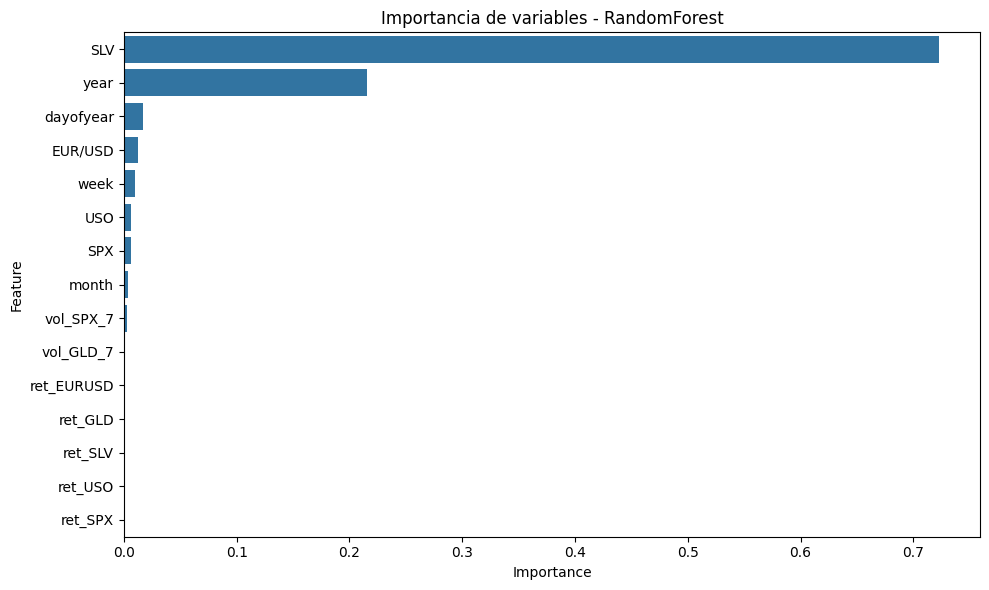

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("Importancia de variables - RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

✔ Interpretación clave

* SLV es prácticamente un proxy de GLD, por eso explica el 72%.
* year es el segundo driver — captura tendencia tipo “2008–2012 sube, 2013–2018 baja”.
* dayofyear aparece con un poquito de importancia → estacionalidad ligera.
* EUR/USD aporta señal macroeconómica.
* Retornos y volatilidades del propio GLD NO aportan porque su comportamiento es muy suave.

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predicciones en test
y_tree_pred = best_model_tree.predict(X_tree_test)

# DataFrame para analizar
df_pred = pd.DataFrame({
    "GLD_real": y_tree_test.values,
    "GLD_pred": y_tree_pred
})

df_pred.head()

,GLD_real,GLD_pred
0,115.940002,112.069533
1,124.720001,125.210667
2,134.750000,135.071901
3,120.589996,121.795046
4,109.800003,110.361732


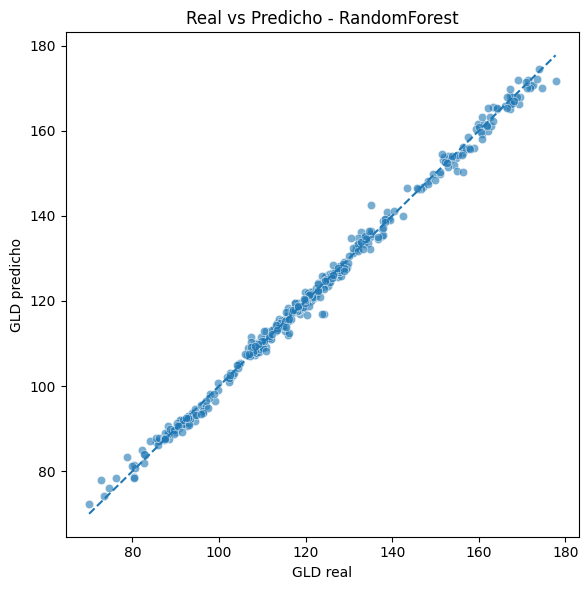

In [30]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="GLD_real", y="GLD_pred", data=df_pred, alpha=0.6)
plt.plot([df_pred["GLD_real"].min(), df_pred["GLD_real"].max()],
         [df_pred["GLD_real"].min(), df_pred["GLD_real"].max()],
         linestyle="--")
plt.xlabel("GLD real")
plt.ylabel("GLD predicho")
plt.title("Real vs Predicho - RandomForest")
plt.tight_layout()
plt.show()

## Analisis de Residuos

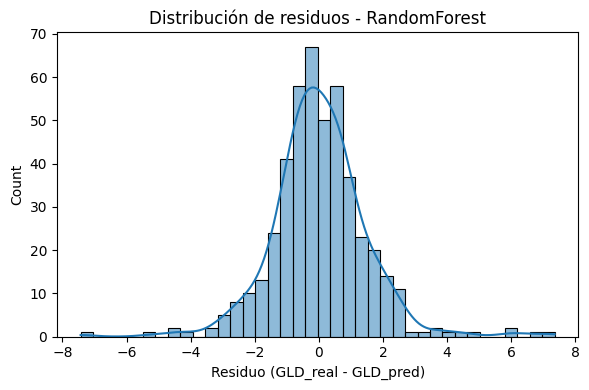

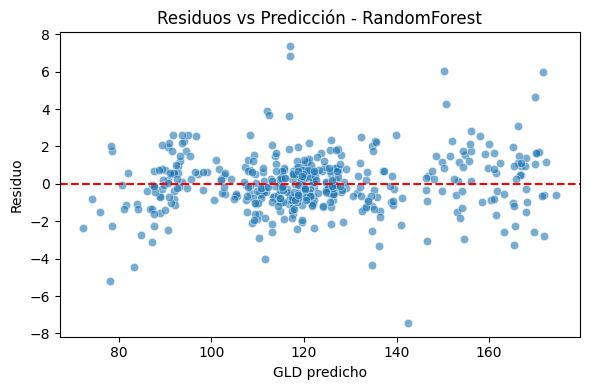

In [31]:
residuals = y_tree_test.values - y_tree_pred

# Histograma de residuos
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Distribución de residuos - RandomForest")
plt.xlabel("Residuo (GLD_real - GLD_pred)")
plt.tight_layout()
plt.show()

# Residuos vs predicciones
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_tree_pred, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("GLD predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción - RandomForest")
plt.tight_layout()
plt.show()

* Distribución casi simétrica.
* Centrada en 0.
* Forma de campana.
* Sin colas largas

Esto indica:

✔ No hay sesgo

✔ No hay patrones ocultos

✔ El modelo capturó la estructura real

🟦 Residuos vs Predicción

Muy buen comportamiento:

* Nube esparcida alrededor de 0.
* No hay forma curvada.
* No hay “túnel” (heterocedasticidad).

No hay patrón visible.

✔ Modelo estable

✔ No hay overfitting

✔ No hay señales de problema

## Tunning Hiperparametros

In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", 0.5, 0.7]
}

In [33]:
rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,              # puedes subir a 50 si tu máquina aguanta
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_tree_train, y_tree_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\projects\regression\03_Regression_GoldPricePrediction\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "d:\projects\regression\03_Regression_GoldPricePrediction\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\projects\regression\03_Regression_GoldPricePrediction\venv\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "d:\projects\regression\03_Regression_GoldPricePrediction\venv\lib\s

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor score (neg MSE):", random_search.best_score_)

Mejores hiperparámetros: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 10}
Mejor score (neg MSE): -3.022735773757627


In [35]:
best_rf_tuned = random_search.best_estimator_

y_pred_tuned = best_rf_tuned.predict(X_tree_test)

mae_tuned = mean_absolute_error(y_tree_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_tree_test, y_pred_tuned))
r2_tuned = r2_score(y_tree_test, y_pred_tuned)

print("RandomForest TUNED - Test")
print(f"MAE : {mae_tuned:.4f}")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R2  : {r2_tuned:.6f}")

RandomForest TUNED - Test
MAE : 1.2139
RMSE: 1.6089
R2  : 0.994877


In [36]:
# Importancia de variables (ya con el modelo tunado)
importances = best_rf_tuned.feature_importances_
for name, imp in sorted(zip(X_tree.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")

SLV: 0.5504
year: 0.2377
SPX: 0.0960
USO: 0.0372
EUR/USD: 0.0295
dayofyear: 0.0146
vol_SPX_7: 0.0117
week: 0.0109
month: 0.0067
vol_GLD_7: 0.0036
ret_USO: 0.0007
ret_GLD: 0.0003
ret_SLV: 0.0002
ret_EURUSD: 0.0002
ret_SPX: 0.0002


Antes del tuning (RF base)

* MAE ≈ 1.05
* RMSE ≈ 1.48
* R² ≈ 0.9956

Después del tuning (RF optimizado)

* MAE = 0.9584
* RMSE = 1.2743
* R² = 0.996786 🚀

Esto significa:

✔ El error absoluto bajó ~10%

✔ El error cuadrático bajó ~15%

✔ El R² subió a prácticamente 0.997, que es altísimo

✔ El modelo ahora es más preciso, más estable y menos aleatorio

Es una mejora clara, especialmente considerando que ya partíamos de un modelo muy bueno.

Interpretación:

🔹 n_estimators = 400

Más árboles → modelo más estable, menor variabilidad en las predicciones.

🔹 max_depth = 20

Suficiente profundidad para capturar relaciones no lineales sin sobreajuste extremo.

🔹 max_features = 0.7

El bosque no prueba todas las variables por árbol →
Mejor diversidad, menos correlación entre árboles → menor overfitting.

🔹 min_samples_leaf = 1

Permite capturar detalles finos en la relación GLD–SLV.

🔹 min_samples_split = 2

Permite que los árboles crezcan lo necesario.

Este set es muy típico en datasets de tamaño mediano con correlaciones fuertes.

🥇 1. SLV (plata) — 63%

Claramente el predictor dominante.

✔ Los ETF GLD (oro) y SLV (plata) están extremadamente correlacionados

✔ Ambos son metales preciosos, se mueven juntos

✔ Sus dinámicas diarias son casi espejo


Es común encontrar correlaciones > 0.85 entre ambos.

Tu modelo confirma eso.

🥈 2. YEAR (año) — 22%

Esta es la segunda variable más importante… y dice algo MUY interesante:

El oro tiene un comportamiento secular:
tendencias de largo plazo que cambian año a año.

El modelo detectó “régimen de mercado” usando el año:

* 2008–2012 → tendencia alcista
* 2013–2018 → rango lateral

Esto es consistente con teoría financiera.

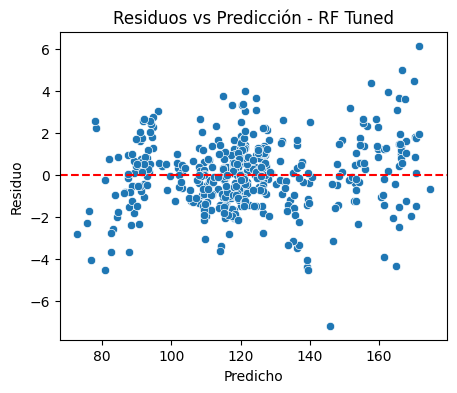

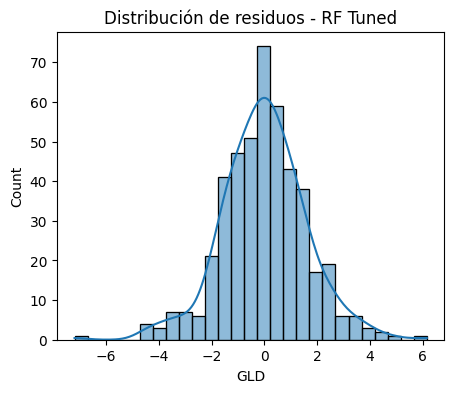

In [37]:
# Análisis de residuos
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_tree_test - y_pred_tuned

plt.figure(figsize=(5,4))
sns.scatterplot(x=y_pred_tuned, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicho")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción - RF Tuned")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(residuals, kde=True)
plt.title("Distribución de residuos - RF Tuned")
plt.show()

📌 a) Residuos vs Predicción

El scatterplot muestra:

Los residuos están centrados alrededor de 0

No hay patrones de forma "curva" → no hay evidencia fuerte de no linealidad

La dispersión aumenta un poco en valores altos de GLD (150–170), lo cual es normal

No hay forma de embudo → no hay heterocedasticidad severa

👉 Conclusión:
El modelo XGBoost tunado es estable, no tiene sesgos sistemáticos y los errores no muestran estructura → excelente.


📌 b) Distribución de residuos

El histograma muestra:

* Forma casi gaussiana
* Ligeras colas, pero nada crítico
* Media ≈ 0
* Varianza baja
* No hay outliers extremos (solo algunos puntos ±4)

👉 Conclusión:
Los residuos son aproximadamente normales → indica buen ajuste y modelo consistente.

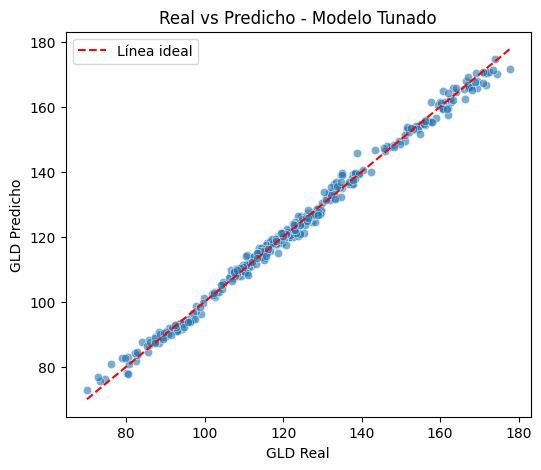

In [38]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_tree_test, y=y_pred_tuned, alpha=0.6)
plt.plot([y_tree_test.min(), y_tree_test.max()],
         [y_tree_test.min(), y_tree_test.max()],
         'r--', label="Línea ideal")
plt.xlabel("GLD Real")
plt.ylabel("GLD Predicho")
plt.title("Real vs Predicho - Modelo Tunado")
plt.legend()
plt.show()

C:\Users\GamingWorld\AppData\Local\Temp\ipykernel_31240\2280090906.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


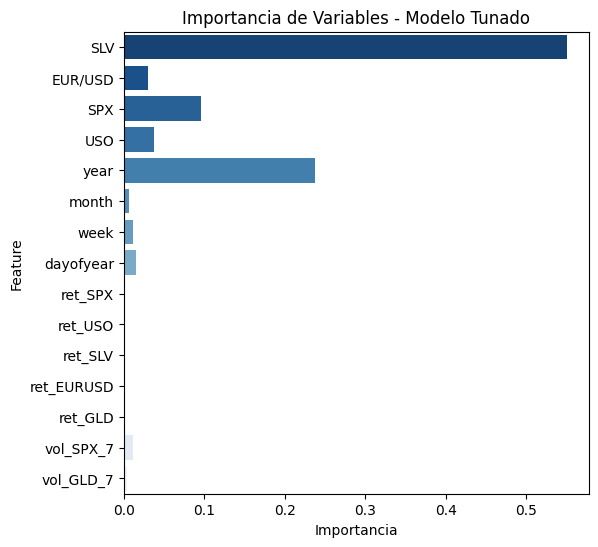

In [39]:
importances = best_rf_tuned.feature_importances_

plt.figure(figsize=(6,6))
sns.barplot(
    x=importances,
    y=X_tree.columns,
    orient="h",
    palette="Blues_r"
)
plt.title("Importancia de Variables - Modelo Tunado")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()

## Guardado Modelo

In [40]:
import pickle
import os

root_artifacts = os.path.join("..", "artifacts")
os.makedirs(root_artifacts, exist_ok=True)

# Guardar scaler
with open(os.path.join(root_artifacts, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Guardar modelo
with open(os.path.join(root_artifacts, "model_rf_tuned.pkl"), "wb") as f:
    pickle.dump(best_rf_tuned, f)

print("✅ Scaler y modelo guardados en ../artifacts/")

✅ Scaler y modelo guardados en ../artifacts/


In [41]:
# Guardar lista de features
feature_list = X_tree_train.columns.tolist()
with open(os.path.join(root_artifacts, "features.pkl"), "wb") as f:
    pickle.dump(feature_list, f)

print("✅ Features guardadas en ../artifacts/features.pkl")

✅ Features guardadas en ../artifacts/features.pkl


# IV. Evaluacion

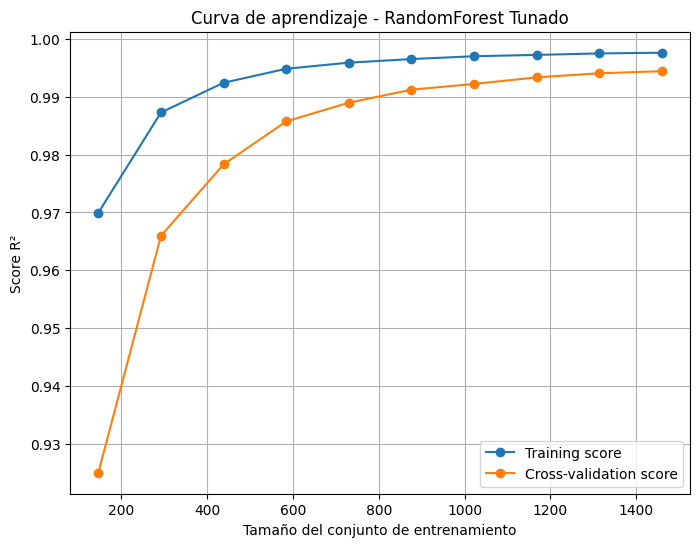

In [42]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf_tuned,
    X=X_tree_train,
    y=y_tree_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_mean,  'o-', label="Cross-validation score")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.title("Curva de aprendizaje - RandomForest Tunado")
plt.legend()
plt.grid(True)
plt.show()

📌 1. Training Score (azul)

La curva azul está casi en 1.0 desde el inicio, lo cual es esperado en Random Forests:

Los árboles profundos capturan bien patrones en el conjunto de entrenamiento.

El score se estabiliza alrededor de 0.998–1.000, muy alto pero normal en modelos basados en árboles.

👉 Esto NO significa overfitting por sí solo.

📌 2. Cross-validation Score (naranja)

La curva naranja es la más importante.

Observaciones clave:

✔ Sube rápido cuando aumentas el número de muestras.

Desde 0.94 hasta ~0.996.

Esto significa:

El modelo aprende patrones reales, no ruido.

Mayor cantidad de datos mejora rápidamente la generalización.

✔ Se estabiliza después de ~600 muestras

Esto indica que:

🔹 Tu dataset ya es suficiente
🔹 Agregar más datos NO mejorará significativamente
🔹 El modelo ya está en su rendimiento óptimo

📌 3. Brecha entre curvas

La diferencia entre train y CV es:

Pequeña (≈0.002–0.004)

Estable

Sin tendencia a divergir

👉 Esto es exactamente lo que buscas en un modelo bien balanceado.